# Projeto de análise de custos em nuvem --- Hyperledger Fabric

Este projeto tem como objetivo auxiliar na predição de recursos necessários para executar uma blockchain Hyperledger Fabric --- ou outras blockchains permissionadas privadas com comportamento similar.</br>
Além dos recursos analisados, com base nos atributos de configuração e transações por segundo (TPS), disponibilizamos uma estimativa de custos para executar elementos de uma organização na computação em nuvem</br>
</br>
Assim, o projeto é dividido em duas grandes seções: Predição de recursos e Calculadora de Custos em um ambiente Cloud.</br><br>

Nas seções, existem blocos que serão demarcados por " 🔵 " para sinalizar um bloco de parametrização e variaveis que podem ser alteradas



# Blockchain Predict (predição dos recursos)

## Configurações
É importante destacar que o modelo é baseado em configurações e entradas do usuário. É recomendado o conhecimento mínimo sobre uma blockchain Hyperledger Fabric e alguns testes preliminares para popular alguns campos. </br>
Na célula abaixo, a estrutura de dados ```BlockchainParameters```representa a configuração e parâmetros reais do arquivo de configuração da blockchain.
 </br>

### BlockchainParameters:
 
 ```GenesisBlockSize``` : indica o espaço ocupado pelo bloco gênese (primeiro bloco ao criar uma nova blockchain). Geralmente carrega poucas informações e na maioria dos casos pode ser irrelevante: <br>
 Os parâmetros listados abaixo interferem diretamente no comportamento da blockchain e devem ser analisados conforme necessidade.

 ```BatchSize```: O BatchSize é composto por dois parâmetros limites para garantir os valores máximos de informações em um bloco da blockchain.
 - ```AbsoluteMaxBytes```: esse parâmetro representa em Bytes qual deve ser o gatilho para o fechamento do bloco, isso é, ao ser atingido o valor de informações, o bloco deve ser fechado e gerado um novo bloco na cadeia.
 - ```MaxMessageCount```: esse parâmetro indica a quantidade de mensagens, no caso, limite transações que podem inseridas dentro do bloco
 ```BatchTimeout```: quando nenhum dos indicadores acima atingir seu gatilho, o *BatchTimeout* busca garantir o tempo máximo para espera do bloco em aberto.
```EndorsementPolicy```: define as políticas da rede para endosso --- assinatura e validação inicial de algum *peer* ---  das transações. O Endosso é normalmente representado por equações lógicas como OR(A,B), AND(A,B) ou OR(A,B,C). Para incluir nos cálculos a quantidades de transações que um Peer deve assinar, consideramos a distribuição das transações de forma uniforme entre os Peers dadas as condições configuradas (desconsiderando o comportamento **forçado** do *clients* em submeter somente a um *peer* para endosso). Nos exemplos OR(A,B), AND(A,B) ou OR(A,B,C) as transações requerem o total de endossos de Peers, respectivamente, 1/2, 2/2 ou 1/3.
<br> 
<br> 

### Tamanhos e campos (*BlockHeaders* e *TransactionFields*)
Durante a execução das transações na blockchain, os campos e cabeçalhos são preenchidos demandando bytes a serem armazenados. Os campos listados abaixo são utilizados posteriormente os cálculos de armazenamento. <br><br>
Esses campos podem ser dimensionados com base no SmartContract executado com alguns experimentos para estimar o seu tamanho. Reccomendamos que utilize a ferramenta [Hyperledger Caliper](https://www.hyperledger.org/projects/caliper) para compor a análise.
Em suma, os campos de ```BlockHeaders``` são campos com valores definidos após o bloco ser encadeado. ```TransactionFields``` por outro lado são campos presentes em cada transação. <br><br>
Mais detalhes na [documentação](https://hyperledger-fabric.readthedocs.io/en/release-2.5/ledger/ledger.html) nas seções [BlockHeaders](https://hyperledger-fabric.readthedocs.io/en/release-2.5/_images/ledger.diagram.4.png)  e [TransactionFields](https://hyperledger-fabric.readthedocs.io/en/release-2.5/_images/ledger.diagram.5.png)


In [147]:
# { 🔵 }

CONF = {
  "BlockchainParameters": {
    "GenesisBlockSize": 0, 
    "BatchSize": {
      "AbsoluteMaxBytes": 10485760,  # Bytes
      "MaxMessageCount": 100000
    }, 
    "BatchTimeout": 600, #Seconds
  "EndorsementPolicy": 1/2,
  }, 

  "BlockHeaders": { # Bytes
    "MetadataSize": 64, 
    "HeaderSize": 68
  }, 

  "TransactionFields": {#Bytes
    "R4": 128, 
    "E4": 1024, 
    "H4": 64, 
    "P4": 256, 
    "S4": 256
  },
  
}



In [148]:
# { 🔵 }
CLOUD_PRICING = { #USD
    # sa-east-1 #AWS São Paulo
    "Storage": {
      "Pricing": 0.19
    }, 
    "NetworkThroughput": {
      "PricingDataTransfer": 0.01,
      "PricingEndpointHour": 0.01
    }, 
    "VirtualMachine": {
      "FilePricing": None,#"./ec2_instances_pricing.csv", #None requires insert manual values InstancesTypes.
       "InstancesTypes": [
      # E.g:
        {"Name": " c6a.large","vCPUs": 2,  "Pricing": 0.1179},
        {"Name": " c6a.xlarge","vCPUs": 4,  "Pricing": 0.2358},
        {"Name": " c6a.2xlarge","vCPUs": 8,  "Pricing": 0.4716},
        {"Name": " c6a.4xlarge","vCPUs": 16,  "Pricing": 0.9432},
        {"Name": " c6a.8xlarge","vCPUs": 32,  "Pricing": 1.8864},
       ]
      
    }, 
    "Additional": 0 # E.g: taxes or discounts
  }

In [149]:
#%matplotlib inline #<< É necessário utilizar se estiver no VSCODE

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

import numpy as np
import pandas as pd
from pandas.plotting import table

pd.options.display.float_format = '{:,.2f}'.format

from IPython.display import Markdown, display

import pprint

In [150]:
#predict.py
TRANSACTION_SIZE     =  np.sum(np.array([fields_values for fields_values in CONF['TransactionFields'].values()]))
BLOCK_HEADERS_SIZE   =  np.sum(np.array([fields_values for fields_values in CONF['BlockHeaders'].values()]))

def calculate_size_total_transacoes(self, total_transactions:int, transaction_size:int) -> int:
   self.size_total_transacoes = total_transactions * transaction_size
   if self.size_total_transacoes > self.absolute_max_bytes:
      print('Undefined: size_total_transacoes > absolute_max_bytes')
      print('size_total_transacoes : ', self.size_total_transacoes)
      return -1
   return self.size_total_transacoes

class StorageDemand:
    def __init__(self):
        self.total_blocks = 0
        self.total_transactions = 0
        self.calculated_total_size_blocks = 0
        self.batch_type = ""
        self.period = 0

class CostPredict:
    def __init__(self):
        self.vm_file_pricing                = CLOUD_PRICING['VirtualMachine']['FilePricing']
        self.instance_types               = CLOUD_PRICING['VirtualMachine']['InstancesTypes']
        self.storage_pricing             = CLOUD_PRICING['Storage']['Pricing']
        self.network_throughput_pricing  = CLOUD_PRICING['NetworkThroughput']['PricingDataTransfer']
        self.additional                  = CLOUD_PRICING['Additional']

In [151]:
def logistic_curve(t, P0, K, r, t0):
    return P0 + (K - P0) / (1 + np.exp(-r * (t - t0)))

### Modelagem da curva de adoção
Para uma modelagem mais abrangente, as predições são geradas com base no tipo período da variável ```PREDICT_TYPE``` que assume os valores de: 'DAY' para dias, 'WEEK' para semana, 'MONTH' para mês e YEAR' para anos. 
<br><br>
Há duas formas de inserir comportamentos estimados de transações por segundo no ambiente.
1. ARRAY: Inserir valores de TPS diretamente no Array 
2. Função Logística: Ajustar os parametros da função logística para gerar algum comportamento ao longo do período (**deixar o ARRAY vazio para auto seleção*)

A função de regressão logística pode simplificar na visualização e estimativas da adoção da tecnologia. Ainda que para uma organização em longo prazo seja díficil ter certeza sobre a demanda de transações, o gráfico da curva pode assumir diferentes comportamentos e auxiliar visualmente na modelagem.

In [152]:
# 🔵 Required PREDICT_TYPE

global PREDICT_TYPE
PREDICT_TYPE = 'MONTH' # 🔵 'DAY':'WEEK':'MONTH':'YEAR'

In [153]:
# 🔵 Caso array [vazio]
global AVG_RATE_TRANSACTIONS

ARRAY = []# 🔵 E.g [50,75,100,150,200,250,320,370,550,750,1000
AVG_RATE_TRANSACTIONS = np.array(ARRAY)

A = len(ARRAY)

t = np.linspace(1, A, A)

In [154]:
# 🔵 Caso Função Logística (default)

# Parâmetros da curva logística
P0 = 5         # 🔵 Transações inicial
K = 1000       # 🔵 Valor máximo transações estimado
r =  0.15      # 🔵 Taxa de crescimento
t0 = A / 4     # 🔵 Ponto de inflexão -> Meio

# Calcula a população usando a função da curva logística

if len(ARRAY) == 0: # Ativar função logística
    A = 120         # 🔵 Numero de períodos. E.g: para 18 meses => PREDICT_TYPE = 'MONTH' e A = 18 

    t = np.linspace(1, A, A)
    AVG_RATE_TRANSACTIONS = logistic_curve(t, P0, K, r, t0)



In [155]:
# Cod Auxiliar de plotagens
def simple_plot(x, y,line_label="", xlabel=f'Tempo ({PREDICT_TYPE})', ylabel="", title="", v_grid=True, tlabel_style="plain", create_df=False):
    #print(f'Ultimo valor "{line_label}" => {y[-1]}')
    if create_df:
        fig, (ax, ax2)= plt.subplots(1, 2, figsize=(12, 4))
    else:
        fig, ax = plt.subplots()
    
    ax.plot(x,y,label=line_label)
    ax.ticklabel_format(style=tlabel_style)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(v_grid)
    
    df = pd.DataFrame({xlabel: x, line_label:y})
    if create_df:
        
        filter_df = df
        filter_df[xlabel] = df[xlabel].astype(int)
        filter_df[line_label] = filter_df[line_label].map('{:,.2f}'.format)


        ax2.axis('off')  # Ocultar os eixos do subplot

        col_widths = [0.2, len(line_label)*0.015]
        tbl = table(ax2, filter_df.iloc[int(A/(A/10)):A:int(A/(A/10))], loc='center', colWidths=col_widths)
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(10)
        tbl.scale(1.2, 1.2)

        # Ajustar o layout para evitar sobreposição
        plt.tight_layout()

    return fig, ax, df

In [156]:
t

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120.])

In [157]:
AVG_RATE_TRANSACTIONS

array([539.74269612, 576.57030423, 612.58603778, 647.42802469,
       680.78280568, 712.39475511, 742.07102469, 769.68215958,
       795.15898006, 818.48660381, 839.69659517, 858.85819042,
       876.0694086 , 891.44866291, 905.12728243, 917.24316699,
       927.93564707, 937.34151072, 945.59208937, 952.81125619,
       959.11417819, 964.60666667, 969.38498494, 973.53599139,
       977.13751694, 980.25889579, 982.96158685, 985.29983847,
       987.32136228, 989.06799208, 990.57631164, 991.8782417 ,
       993.00158078, 993.97049752, 994.80597493, 995.5262082 ,
       996.14695858, 996.68186673, 997.14272899, 997.53973996,
       997.88170498, 998.17622575, 998.42986208, 998.64827265,
       998.83633729, 998.99826303, 999.13767607, 999.25770131,
       999.3610312 , 999.44998526, 999.52656147, 999.59248067,
       999.64922485, 999.69807021, 999.74011563, 999.77630731,
       999.80745989, 999.83427473, 999.85735563, 999.8772224 ,
       999.89432252, 999.90904121, 999.92171004, 999.93

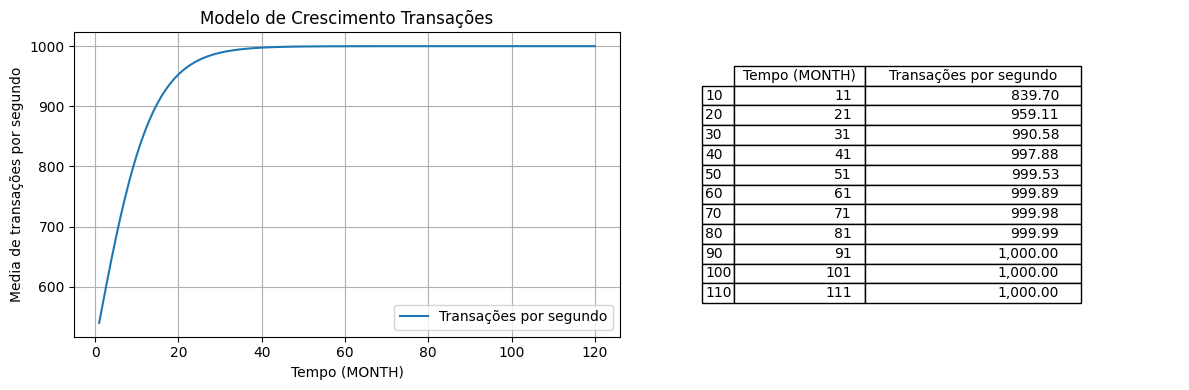

In [158]:
#Plotagem da curva de transações com base nas entradas
fig, ax, df = simple_plot(x= t,y= AVG_RATE_TRANSACTIONS, line_label= 'Transações por segundo', ylabel= 'Media de transações por segundo', title= 'Modelo de Crescimento Transações', create_df=True)
plt.show()


In [159]:
# Exemplos de modelagem auxiliar

# A = 120         # Numero de períodos

# t = np.linspace(0, A - 1, A)

# # Parâmetros da curva logística
# P0 = 10         # Transações inicial
# K = 1500       # Valor máximo transações estimado
# r =  0.09       # Taxa de crescimento
# t0 = A/10     # Ponto de inflexão 

# example_curve_1 = []
# if len(ARRAY) == 0: # Ativar função logistica
#     example_curve_1 = logistic_curve(t, P0, K, r, t0)

# r =  0.085      # Taxa de crescimento
# t0 = A-(A/5)     # Ponto de inflexão 
# example_curve_2 = []
# if len(ARRAY) == 0: # Ativar função logistica
#     example_curve_2 = logistic_curve(t, P0, K, r, t0)




# fig, ax, df = simple_plot(x= t,y= example_curve_1, line_label= 'Exemplo 1', ylabel= 'Media de transações por segundo', title= 'Outros exemplos para modelagem  de crescimento')
# ax.plot(t, example_curve_2, label='Exemplo 2')
# ax.legend()
# fig.set_size_inches(4.5,3)
# plt.show()



### Demanda de Armazenamento e Transações

**TRANSAÇÕES**

In [160]:

def expand_transactions_by_period(predict_type, rate_transactions_per_second):
    SECONDS_PER_DAY  = 86400
    return {
    'DAY': lambda rate_transactions_per_second: rate_transactions_per_second * SECONDS_PER_DAY,
    'WEEK': lambda rate_transactions_per_second: rate_transactions_per_second * SECONDS_PER_DAY * 7,
    'MONTH': lambda rate_transactions_per_second: rate_transactions_per_second * SECONDS_PER_DAY * 30,
    'YEAR': lambda rate_transactions_per_second: rate_transactions_per_second * SECONDS_PER_DAY * 365
    }[predict_type](rate_transactions_per_second)

total_transactions_by_period = expand_transactions_by_period(PREDICT_TYPE, AVG_RATE_TRANSACTIONS)

Abaixo, a plotagem da soma do total 'Transações (Committed)' no período apresenta uma expansão de transações por **segundo** para o período escolhido. Por exemplo, para uma predição ```PREDICT_TYPE = DAY``` para dias, dado o valor de X transações por segundo (TPS), resultado na soma de transações equivalente a Y transações total no dia
<br>
O gráfico é exibido em notação científica para melhorar a visualização.
<br>

💡 'Transações (Committed)' são aquelas gravadas na blockchain

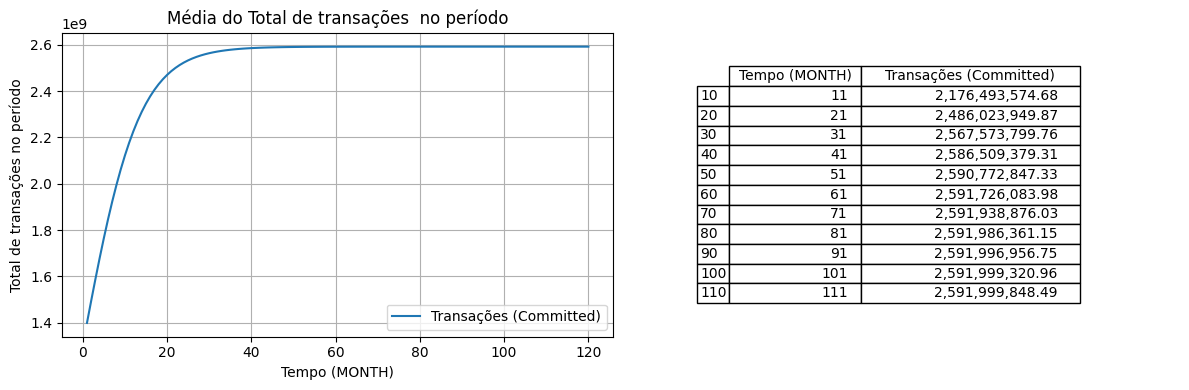

In [161]:
# Plotagem da soma do total transações estimada no período style='scientific'
fig, ax, df = simple_plot(x= t, y= total_transactions_by_period, line_label= 'Transações (Committed)', ylabel= 'Total de transações no período', title= 'Média do Total de transações  no período', tlabel_style='scientific', create_df=True)
plt.show()

#### ESTIMATIVA DE GERAÇÃO DOS BLOCOS:
<br>

Com a informação de TPS e a soma de transações em um período, podemos estimar a quantidade de blocos gerados a partir das configurações de ```BatchSize = AbsoluteMaxBytes | MaxMessageCount``` e ```BatchTimeout``` conforme descrevemos na seção de configurações.
<br>

A quantidade de blocos tem impacto na rede, pois a quantidade de blocos multiplicado pelos [tamanhos de cabeçalho](#tamanhos-e-campos-blockheaders-e-transactionfields) será computado também no total de armazenamento.
<br>

Além disso, sabendo a quantidade de transações dentro de um bloco e o [tamanho de cada transação](#tamanhos-e-campos-blockheaders-e-transactionfields) podemos estimar o tamanho total do bloco, e cumulativamente o tamanho total da blockchain.

In [162]:
# Bloco principal da análise de geração de blocos com base nas transações
def estimate_blocks(avg_tps, total_transactions_period):
    total_blocks = None
    batch_type  = ""
    
    #Qual o tempo necessário para fechar um bloco para max_message
    time_to_batch_messages = CONF['BlockchainParameters']['BatchSize']['MaxMessageCount'] / avg_tps

    #Quantas transações são necessárias para fechar um bloco com max_bytes
    aggregate_total_transactions_if_batch_max_bytes = CONF['BlockchainParameters']['BatchSize']['AbsoluteMaxBytes'] / TRANSACTION_SIZE
    time_to_batch_bytes  = aggregate_total_transactions_if_batch_max_bytes / avg_tps

    total_blocks = None
    
    if time_to_batch_messages >= CONF['BlockchainParameters']['BatchTimeout']  and \
            time_to_batch_bytes >=  CONF['BlockchainParameters']['BatchTimeout'] :# calcular para encadeamento batchtimeout

        
        aggregate_total_transactions_if_batch_timeout = CONF['BlockchainParameters']['BatchTimeout'] * avg_tps
        total_blocks = total_transactions_period / aggregate_total_transactions_if_batch_timeout
        batch_type = "batch_timeout"

    elif time_to_batch_messages < time_to_batch_bytes: # calcular para encadeamento batch messages
        total_blocks = total_transactions_period / time_to_batch_messages
        batch_type = "batch_message"
        
    
    elif time_to_batch_bytes    < time_to_batch_messages:# calcular para encadeamento batch bytes
        total_blocks = total_transactions_period / time_to_batch_bytes
        batch_type = "batch_bytes"
        
    else:
        raise Exception
        
    
    return total_blocks, batch_type

storage_demand = []
for i_period in range(0,A): 

    avg_t = AVG_RATE_TRANSACTIONS[i_period]
    transactions_by_period = total_transactions_by_period[i_period]

    i_storage_demand = StorageDemand() # Salvar no objeto com atributos que serão utilizados posteriormente
    i_storage_demand.period                                         = i_period    
    i_storage_demand.total_transactions                             = transactions_by_period
    i_storage_demand.total_blocks, i_storage_demand.batch_type      = estimate_blocks(avg_t, transactions_by_period)
    i_storage_demand.calculated_total_size_blocks                   = (i_storage_demand.total_blocks * BLOCK_HEADERS_SIZE) + (i_storage_demand.total_transactions * TRANSACTION_SIZE)
    
    storage_demand.append(i_storage_demand)
    


O total cumulativo de blocos é exibido abaixo. 

💡 Note que, sempre há um crescimento da quantidade de blocos e consequentemente da blockchain. Por exemplo, mesmo que a quantidade de ativos (*Assets*) se mantenha a mesma, cada transação pode alterar algum atributo e, consequentemente, cada alteração (transação) gerará um registro gravado na blockchain.
<br>
Esse fator implicará no custo de armazenamento que veremos a frente.



In [163]:
# Soma cumulativa dos tamanhos dos blocos
i_period           = np.array([s.period for s in storage_demand])
cumulative_blocks  = np.cumsum( np.array([s.total_blocks for s in storage_demand]) )

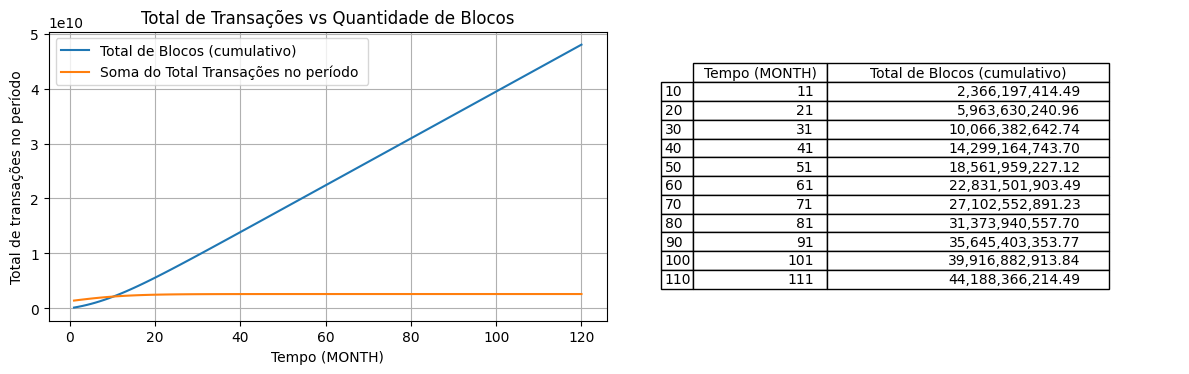

In [164]:
# Plotagem da soma do toal transações estimada no período
fig, ax, df = simple_plot(x= t, y= cumulative_blocks, line_label='Total de Blocos (cumulativo)', ylabel='Total de transações no período', title= 'Total de Transações vs Quantidade de Blocos', tlabel_style='sci', create_df=True)
ax.plot(t, total_transactions_by_period, label='Soma do Total Transações no período ')
ax.legend()
plt.show()

**ARMAZENAMENTO**

Com base nas informações do tamanho de cada bloco, podemos estimar a demanda de armazenamento total ao longo do período.

In [165]:
BYTE_TO_GIGA =  pow(1024 , 3)
cumulative_size_GB  = np.cumsum( np.array([s.calculated_total_size_blocks for s in storage_demand]) /  BYTE_TO_GIGA )

BYTE_TO_TERA =  pow(1024 , 4)
cumulative_size_TB  = np.cumsum( np.array([s.calculated_total_size_blocks for s in storage_demand]) /  BYTE_TO_TERA )

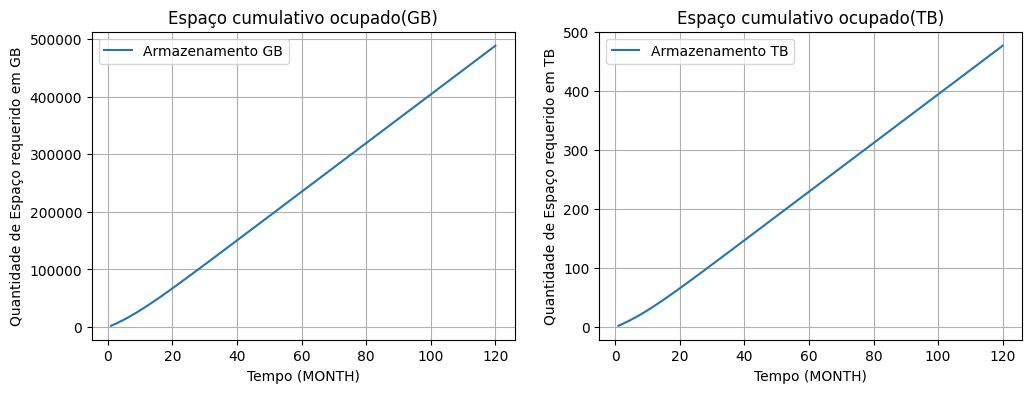

,Tempo (MONTH),GB,TB
10,11,"32,554.78",31.79
20,21,"71,254.93",69.58
30,31,"112,639.37",110.00
40,41,"154,683.96",151.06
50,51,"196,879.26",192.26
60,61,"239,108.37",233.50
70,71,"281,345.03",274.75
80,81,"323,583.37",316.00
90,91,"365,822.09",357.25
100,101,"408,060.90",398.50


In [166]:
# ARMAZENAMENTO REQUERIDO GB / TB
# fig, ax, df1 = simple_plot(x= t, y=cumulative_size_GB, line_label='Armazenamento GB', ylabel='Quantidade de Espaço requerido em GB', title= 'Espaço cumulativo ocupado(GB)', tlabel_style='plain')
# fig, ax, df2 = simple_plot(x= t, y=cumulative_size_TB, line_label='Armazenamento TB', ylabel='Quantidade de Espaço requerido em TB', title= 'Espaço cumulativo ocupado(TB)', tlabel_style='plain')

xlabel=f'Tempo ({PREDICT_TYPE})'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(t,cumulative_size_GB,label='Armazenamento GB')
ax1.ticklabel_format(style='plain')
ax1.set_xlabel(xlabel)
ax1.set_ylabel('Quantidade de Espaço requerido em GB')
ax1.set_title('Espaço cumulativo ocupado(GB)')
ax1.legend()
ax1.grid(True)

ax2.plot(t,cumulative_size_TB,label='Armazenamento TB')
ax2.ticklabel_format(style='plain')
ax2.set_xlabel(xlabel)
ax2.set_ylabel('Quantidade de Espaço requerido em TB')
ax2.set_title('Espaço cumulativo ocupado(TB)')
ax2.legend()
ax2.grid(True)

plt.show()

df = pd.DataFrame({xlabel: t, 'GB': cumulative_size_GB, 'TB': cumulative_size_TB})
df[xlabel] = df[xlabel].fillna(0).astype(int)
df.iloc[int(A/(A/10)):A:int(A/(A/10))]


## Demanda CPU

O consumo de CPU é estimado conforme a taxa de transações por segundo. No entanto, diferentes elementos da rede com diferentes workloads, necessitam processam quantidades de transações de forma independente.
<br>
No Hyperledger Fabric podemos considerar dois tipos de nodos que requerem maior capacidade de CPU: os Peers e Nodos de Ordenação (*Ordering Service*).



### Demanda CPU ~ Ordering Service

Na arquitetura do Hyperledger Fabric, os elementos que compõem a rede das organizações majoritariamente são os **Peers**, mas também é necessário um cluster de nodos responsáveis pela ordenação das transações (Ordering Service). Para este modelo, consideramos que a Organização manterá um dos nodos de ordenação em sua infraestrutura.

Abaixo são realizados os cálculos para estimativa da quantidade de CPU de ordenação necessária para o TPS total da rede. Essa estimativa é feita com base nas variáveis baseadas em um "benchmark" de performance que pode mensurado executando o Hyperledger Calyper e acompanhamento a carga na CPU.  ```vCPU_BASE_OSN``` e ```vCPU_BASE_TPS_OSN```, são respectivamente, a quantidade de CPU e o total de transações que as CPUs suportaram.

In [167]:
# { 🔵 }
vCPU_BASE_OSN     =  1
vCPU_BASE_TPS_OSN = 150 

In [168]:
# Predição de CPU com base em entradas fornecidas
aggregate_total_required_vcpu_osn = np.array([])
ordering_transactions = AVG_RATE_TRANSACTIONS

for tps in ordering_transactions:
    target_required_vcpu  = vCPU_BASE_OSN

    required_vcpu_current_tps = tps / vCPU_BASE_TPS_OSN

    if required_vcpu_current_tps > 1:
        target_required_vcpu = vCPU_BASE_OSN + (vCPU_BASE_OSN * int(required_vcpu_current_tps))
        
    aggregate_total_required_vcpu_osn = np.append(aggregate_total_required_vcpu_osn, target_required_vcpu)

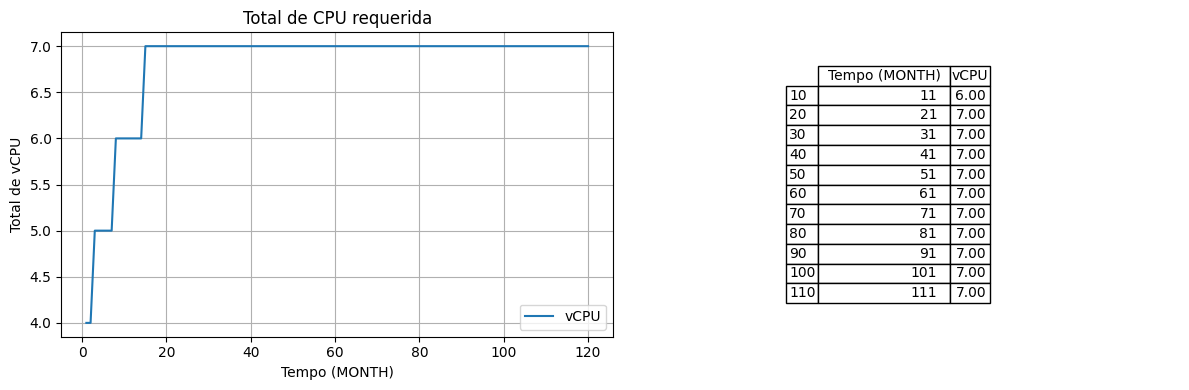

In [169]:
fig, ax, df = simple_plot(x= t, y=aggregate_total_required_vcpu_osn, line_label='vCPU', ylabel='Total de vCPU', title= 'Total de CPU requerida', tlabel_style='plain', create_df=True)
plt.show()

A capacidade de processamento de transações por segundos sempre deve ser igual ou superior a demanda da rede, evitando gargalos.
<br>
A estimativa busca otimizar o uso dos recursos para evitar a alocação excessiva de computação, no entanto, logo após o redimensionamento de recurso, há uma margem de sobra até o próximo ciclo de aumento.
<br>
Abaixo a comparação da capacidade de processamento do OSN. 

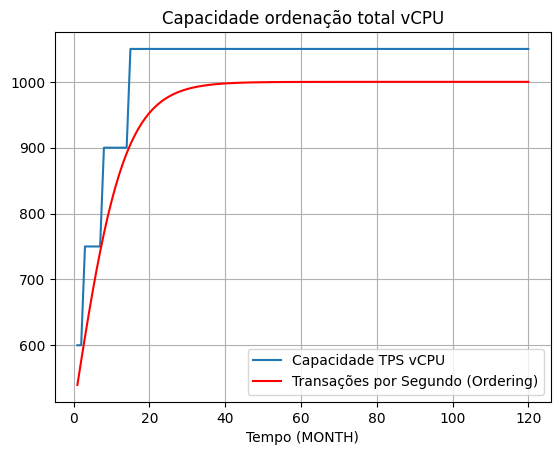

In [170]:
# Grafico da capacidade de processamento OSN
osn_total_vcpu_tps = aggregate_total_required_vcpu_osn*vCPU_BASE_TPS_OSN

fig, ax, df = simple_plot(x= t, y= osn_total_vcpu_tps, line_label='Capacidade TPS vCPU ', ylabel='', title= 'Capacidade ordenação total vCPU', tlabel_style='plain')
ax.plot(t, ordering_transactions, label='Transações por Segundo (Ordering)', color='red')
plt.legend()
plt.show()



## CPU PEER

A CPU do Peer processa uma quantidade significativa de transações. Isso porque todas as transações gravadas sempre devem ser executadas por todos os peers, não há um modo de distribuição parcial.

As transações de endosso, por outro lado, que seguem a politica de ```EndorsementPolicy```, não necessariamente passam por todos os peers, sendo o mínimo definido suficiente.

Em suma, um peer deve processar as transações de endosso submetidas somadas todas as transações da rede.

### Políticas de Endosso --- Endorsement Transactions

As transações de endosso são aqueles que um *client* submete a uma quantidade de Peers necessários definidos pela ```EndorsementPolicy```. Essas transações são uma pré-validação e assinatura do peer sobre a transação que se deseja executar.
Neste sentido, dada a taxa de transações por segundo da rede, é possível estimar a quantidade provável de transações endossadas pelo Peer conforme a política de endosso.

Abaixo, é exibida a plotagem da comparação 'Endorsement Transactions' da rede em comparação ao total de transações *Commited* apresentado anteriomente, com base no parametro ```CONF['BlockchainParameters']['EndorsementPolicy']```
<br>
💡 'Endorsement Transactions'  são aquelas que o peer deve pré-assinar para ser submetida na rede


In [171]:
#endorsement_transactions
endorsement_transactions = total_transactions_by_period * CONF['BlockchainParameters']['EndorsementPolicy']

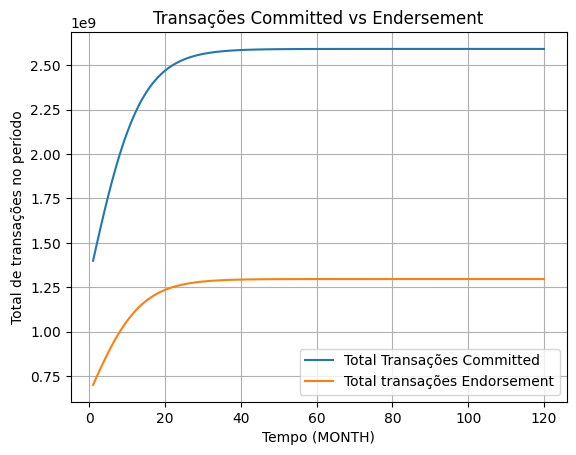

,Tempo (MONTH),Total Transações Committed,Endorsement
10,11.00,"2,176,493,574.68","1,088,246,787.34"
20,21.00,"2,486,023,949.87","1,243,011,974.93"
30,31.00,"2,567,573,799.76","1,283,786,899.88"
40,41.00,"2,586,509,379.31","1,293,254,689.66"
50,51.00,"2,590,772,847.33","1,295,386,423.66"
60,61.00,"2,591,726,083.98","1,295,863,041.99"
70,71.00,"2,591,938,876.03","1,295,969,438.02"
80,81.00,"2,591,986,361.15","1,295,993,180.57"
90,91.00,"2,591,996,956.75","1,295,998,478.37"
100,101.00,"2,591,999,320.96","1,295,999,660.48"


In [172]:
fig, ax, df = simple_plot(x= t, y= total_transactions_by_period, line_label='Total Transações Committed', ylabel= 'Total de transações no período', title= 'Transações Committed vs Endersement', tlabel_style='sci')
ax.plot(t, endorsement_transactions, label='Total transações Endorsement')
ax.legend()

plt.show()
df['Endorsement'] = pd.Series(endorsement_transactions)

df.iloc[int(A/(A/10)):A:int(A/(A/10))]

**PARÂMETROS:**

Assim como para o nodo de Ordering Service, para estimativas de CPU do *Peer* são necessárias as parametrizações de base de quantidade de CPU *versus* processamento suportado, respetivamente ```vCPU_BASE_PEER``` e ```vCPU_BASE_PEER_TPS```

In [173]:
# { 🔵 }
vCPU_BASE_PEER     =  2
vCPU_BASE_PEER_TPS = 200 

A predição é realizada com base na capacidade de processamentos das transações de endosso e gravadas.

In [174]:
# Predição de CPU com base em entradas fornecidas
aggregate_total_required_vcpu_peer = np.array([])

peer_committed_transactions = AVG_RATE_TRANSACTIONS
peer_endorsement_transactions = AVG_RATE_TRANSACTIONS * CONF['BlockchainParameters']['EndorsementPolicy']
peer_endorsement_committed_transactions = peer_committed_transactions + peer_endorsement_transactions

for tps in peer_endorsement_committed_transactions:
    target_required_vcpu  = vCPU_BASE_PEER

    required_vcpu_current_tps = tps / vCPU_BASE_PEER_TPS

    if required_vcpu_current_tps > 1:
        target_required_vcpu = vCPU_BASE_PEER + (vCPU_BASE_PEER * int(required_vcpu_current_tps))
        
    aggregate_total_required_vcpu_peer = np.append(aggregate_total_required_vcpu_peer, target_required_vcpu)

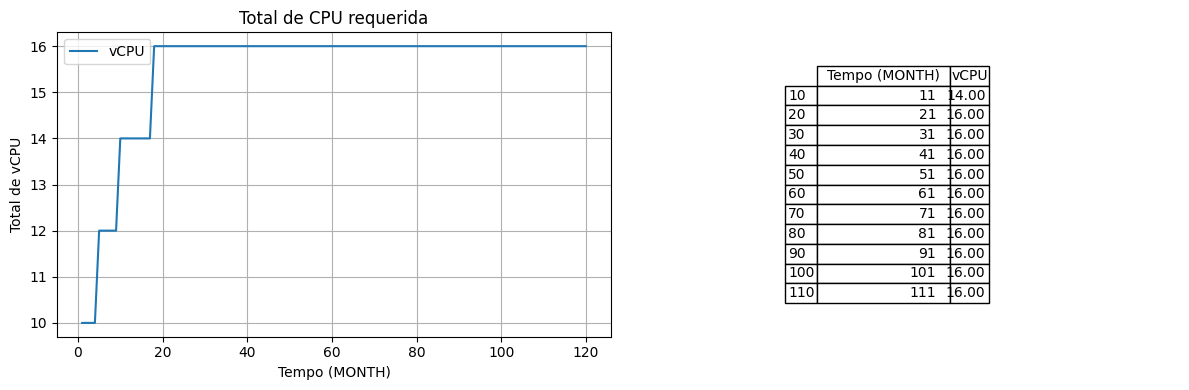

In [175]:
#Gráfico de CPU requerida para o Peer
fig, ax, df = simple_plot(x= t, y=aggregate_total_required_vcpu_peer, line_label='vCPU', ylabel='Total de vCPU', title= 'Total de CPU requerida', tlabel_style='plain', create_df=True)

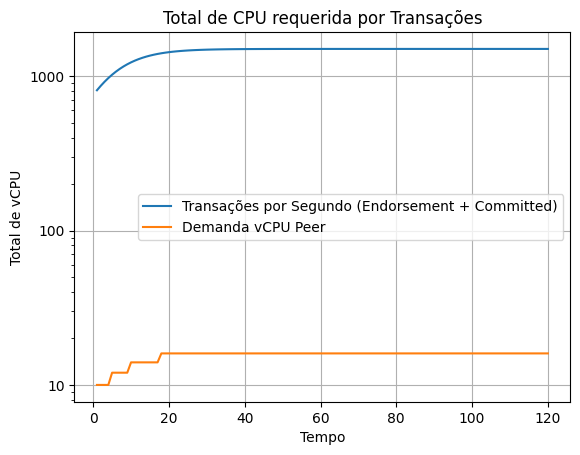

,Tempo MONTH,TPS Committed + Endorsement,vCPU
10,11.00,"1,259.54",14.00
20,21.00,"1,438.67",16.00
30,31.00,"1,485.86",16.00
40,41.00,"1,496.82",16.00
50,51.00,"1,499.29",16.00
60,61.00,"1,499.84",16.00
70,71.00,"1,499.96",16.00
80,81.00,"1,499.99",16.00
90,91.00,"1,500.00",16.00
100,101.00,"1,500.00",16.00


In [176]:
# Plotagem TPS e vCPU Peer
fig, ax = plt.subplots()

plt.semilogy(t, peer_endorsement_committed_transactions, label='Transações por Segundo (Endorsement + Committed)')
plt.plot(t, aggregate_total_required_vcpu_peer, label=f'Demanda vCPU Peer ')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU requerida por Transações')
plt.legend()
plt.show()

df = pd.DataFrame({f'Tempo {PREDICT_TYPE}': t, 'TPS Committed + Endorsement': peer_endorsement_committed_transactions, 'vCPU':aggregate_total_required_vcpu_peer})
df.iloc[int(A/(A/10)):A:int(A/(A/10))]

#### [Adicional] Explorando políticas de endosso ```CONF['BlockchainParameters']['EndorsementPolicy']```

Alguns trabalhos exploram como as políticas de endosso geram carga no processamento. 
<br>
Exploramos abaixo um exemplo para 'AND(A,B)'```CONF['BlockchainParameters']['EndorsementPolicy'] = 2/2``` como representação de endosso de todos os peers.
<br>
O exemplo é somente para fins de comparação e não interfere nos demais gráficos:

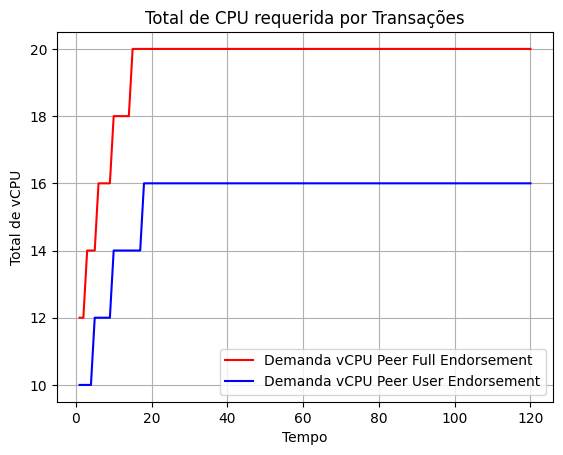

In [177]:
simulated_aggregate_total_required_vcpu_peer = np.array([])

simulated_peer_committed_transactions = AVG_RATE_TRANSACTIONS
simulated_peer_endorsement_transactions = AVG_RATE_TRANSACTIONS * 2/2#CONF['BlockchainParameters']['EndorsementPolicy']
simulated_peer_endorsement_committed_transactions = simulated_peer_committed_transactions + simulated_peer_endorsement_transactions

for tps in simulated_peer_endorsement_committed_transactions:
    simulated_target_required_vcpu  = vCPU_BASE_PEER

    simulated_required_vcpu_current_tps = tps / vCPU_BASE_PEER_TPS

    if simulated_required_vcpu_current_tps > 1:
        simulated_target_required_vcpu = vCPU_BASE_PEER + (vCPU_BASE_PEER * int(simulated_required_vcpu_current_tps))
        
    simulated_aggregate_total_required_vcpu_peer = np.append(simulated_aggregate_total_required_vcpu_peer, simulated_target_required_vcpu)

# Plotagem  vCPU Peer endorsement
fig, ax = plt.subplots()

plt.plot(t, simulated_aggregate_total_required_vcpu_peer, label=f'Demanda vCPU Peer Full Endorsement', color='r')
plt.plot(t, aggregate_total_required_vcpu_peer, label=f'Demanda vCPU Peer User Endorsement', color='b')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU requerida por Transações')
plt.legend()
plt.show()

### Fim da seção de análise de recursos computacionais e demanda:
Com base nas informações de entrada, as estimativas de recursos computacionais como computação e armazenamento foram atingidas. 
<br>
Esses resultados podem ser utilizados de referência para a criação de uma blockchain de forma independente do ambiente, isto é, local ou em nuvem.
<br>
Resumindo: 
- principais resultados com valores máximos:

In [178]:
print(f'Período                     = {A} {PREDICT_TYPE}\'s ')
max_storage_GB = cumulative_size_GB.max()
max_storage_TB = cumulative_size_TB.max()
print(f'Máximo Armazenamento        = {max_storage_GB:.2f} GB |  {max_storage_TB:.2f} TB')

max_blocks = cumulative_blocks.max()
print(f'Total de blocos             = {max_blocks:.2f}')
print(f'Máximo CPU OrderingService  = {aggregate_total_required_vcpu_osn.max()}')
print(f'Máximo CPU Peer             = {aggregate_total_required_vcpu_peer.max()}')


Período                     = 120 MONTH's 
Máximo Armazenamento        = 488314.66 GB |  476.87 TB
Total de blocos             = 48032701923.41
Máximo CPU OrderingService  = 7.0
Máximo CPU Peer             = 16.0


# CUSTOS ESTIMADOS PARA PROVISIONAMENTO DOS RECURSOS EM NUVEM

Esta seção descreve e busca estimar com base nos resultados anteriores, o custo para execução em nuvem.
<p>Não é necessário conhecimento aprofundado sobre a execução e criação de recursos em nuvem, mas os preços de referência destes recursos devem consultados. Algumas observações sobre os valores é verificar o tipo de cobrança mês/hora, o tipo de moeda (normalmente em dólares) e a região de instalação dos recursos (normalmente, as regiões do Brasil tem um custo maior se comparado com EUA).


In [179]:
# Exibindo valores de configuração 
pprint.pprint(CLOUD_PRICING)

{'Additional': 0,
 'NetworkThroughput': {'PricingDataTransfer': 0.01,
                       'PricingEndpointHour': 0.01},
 'Storage': {'Pricing': 0.19},
 'VirtualMachine': {'FilePricing': None,
                    'InstancesTypes': [{'Name': ' c6a.large',
                                        'Pricing': 0.1179,
                                        'vCPUs': 2},
                                       {'Name': ' c6a.xlarge',
                                        'Pricing': 0.2358,
                                        'vCPUs': 4},
                                       {'Name': ' c6a.2xlarge',
                                        'Pricing': 0.4716,
                                        'vCPUs': 8},
                                       {'Name': ' c6a.4xlarge',
                                        'Pricing': 0.9432,
                                        'vCPUs': 16},
                                       {'Name': ' c6a.8xlarge',
                                       

## Armazenamento 
Os provedores de nuvem fornecem diferentes tipos de armazenamento e em diferentes classes. As estimativas criadas são baseada para armazenamento do tipo File Systems, como EBS, EFS ou similares, com 100% de uso, ou seja, sem classes de armazenamento de acesso infrequente. Geralmente, o valor cobrado é em GigaBytes/mês em dólares.
<p>É importante ressaltar que a maioria dos provedores consideram 730 horas mês, isso significa dizer que uma semana, é em média cobrada como 730 * 0.25, o que resulta em 182,5 ao contrário de 7 * 24 = 168.

Essa abordagem visa  **minimizar** as divergências de meses com 30 e 31 dias.

In [180]:
# Calculo de armazenamento-instancia-hora
def convert_period_month(predict_type): #BASED AWS CALCULATOR
    VOLUME_MONTH_HOURS  = 730
    return {
    'DAY'   : (( VOLUME_MONTH_HOURS /  4.34 ) / VOLUME_MONTH_HOURS) / 7, #0,0329
    'WEEK'  : ( VOLUME_MONTH_HOURS /  4.34 ) / VOLUME_MONTH_HOURS, # 0,2304
    'MONTH' : VOLUME_MONTH_HOURS / VOLUME_MONTH_HOURS, # 1
    'YEAR'  : (VOLUME_MONTH_HOURS / VOLUME_MONTH_HOURS) * 12, #12 
    }[predict_type]


convert_period_pricing_month = convert_period_month(PREDICT_TYPE)
print()
total_storage_cost = cumulative_size_GB * (CostPredict().storage_pricing  * convert_period_pricing_month)

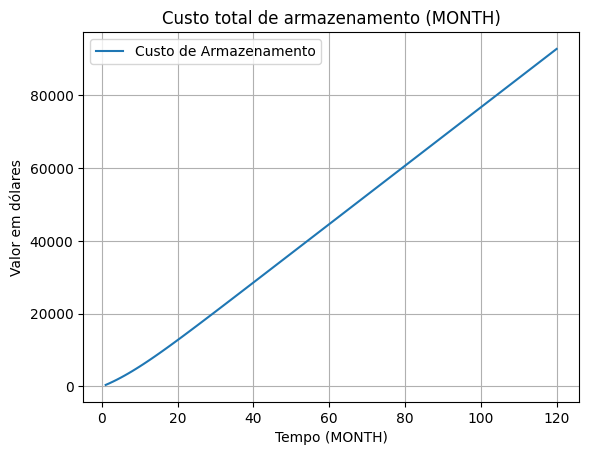

,Tempo(MONTH),Custo/MONTH
10,11.00,"6,185.41"
20,21.00,"13,538.44"
30,31.00,"21,401.48"
40,41.00,"29,389.95"
50,51.00,"37,407.06"
60,61.00,"45,430.59"
70,71.00,"53,455.56"
80,81.00,"61,480.84"
90,91.00,"69,506.20"
100,101.00,"77,531.57"


In [181]:
# Plotagem da soma do total transações estimada no período

fig, ax, df = simple_plot(x= t, y= total_storage_cost, line_label='Custo de Armazenamento', ylabel='Valor em dólares', title= f'Custo total de armazenamento ({PREDICT_TYPE})', tlabel_style='plain', create_df=False)

plt.show()
df = pd.DataFrame({f'Tempo({PREDICT_TYPE})': t, f'Custo/{PREDICT_TYPE}': total_storage_cost})
df.iloc[int(A/(A/10)):A:int(A/(A/10))]

 ## Computação
 
 Geralmente a computação possui um custo  em horas e proporcionalidade direta de tamanho custo. Por exemplo, uma instância com o dobro de CPU, custará proporcionalmente o dobro, mas isso não é uma regra. É importante confirmar os valores para cada tipo de instância.
 <p>Também, os tipos de instância variam de cada provedor, tanto em performance, quanto em quantidade de vCPUs. Alguns disponibilizam quantidade flexível de CPU e outros não.

In [182]:
#

df = pd.Series([])
if CostPredict().vm_file_pricing != None:

    df = pd.read_csv(CostPredict().vm_file_pricing)
    df['vCPUs'] = df['vCPUs'].str.replace(r'\D+', '', regex=True)
    df['Pricing'] = df['Pricing'].str.replace(r'[^0-9.]', '', regex=True)

    df['vCPUs'] = pd.to_numeric(df['vCPUs'])
    df['Pricing'] = pd.to_numeric(df['Pricing'])
elif len(CostPredict().instance_types) != 0:
    df = pd.DataFrame.from_dict(CostPredict().instance_types)
else:
    display(Markdown(f'# ⛔ Falha ao  carregar modelos de instâncias'))



In [183]:
# Valores de entrada
df

,Name,vCPUs,Pricing
0,c6a.large,2,0.12
1,c6a.xlarge,4,0.24
2,c6a.2xlarge,8,0.47
3,c6a.4xlarge,16,0.94
4,c6a.8xlarge,32,1.89


### Provisionamento

Considerando os modelos de instância versus demanda de CPU, é necessário garantir que a instância provisionada tenha maior capacidade.
<br>Isso implicará que algumas vezes a computação provisionada será maior que o necessário, pois não há um modelo intermediário entre os intervalos.

In [184]:
# Carregando o proviosanamento
def provisioned_instance_types(required_vcpu):
    provisioned_vcpu = np.array([])

    # Iterar sobre os elementos do array
    for vcpu in required_vcpu:
        # Verificar se o valor existe na coluna do DataFrame
        if vcpu in df['vCPUs'].values:
            # Se existir, adiciona o valor ao novo array
            type = df[(df['vCPUs'] == vcpu)].iloc[0].to_dict()
            provisioned_vcpu = np.append(provisioned_vcpu, type)
        else:
            # Se não existir, pega o valor mais próximo na coluna do DataFrame
            next_type = df[(df['vCPUs'] > vcpu)].iloc[0].to_dict()
            provisioned_vcpu = np.append(provisioned_vcpu, next_type)

    return provisioned_vcpu

In [185]:
provisioned_instance_peer = provisioned_instance_types(aggregate_total_required_vcpu_peer)
provisioned_instance_osn = provisioned_instance_types(aggregate_total_required_vcpu_osn)

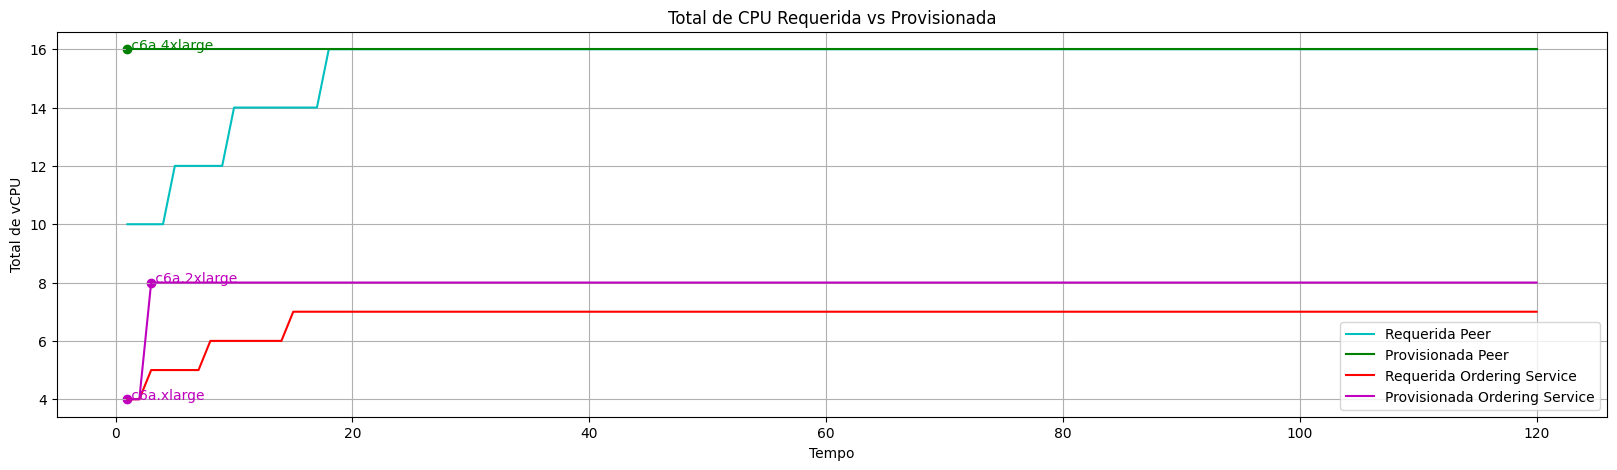

In [186]:
fig, ax = plt.subplots(1, figsize=(20,5))

ax.plot(t, aggregate_total_required_vcpu_peer, label='Requerida Peer', color='c')
plot_provisioned_instance_peer = [x['vCPUs'] for x in provisioned_instance_peer]
ax.plot(t, plot_provisioned_instance_peer, label='Provisionada Peer', color='g')

ax.plot(t, aggregate_total_required_vcpu_osn, label='Requerida Ordering Service', color='r')
plot_provisioned_instance_osn = [x['vCPUs'] for x in provisioned_instance_osn]
ax.plot(t, plot_provisioned_instance_osn, label='Provisionada Ordering Service', color='m')


###########################################
### Plot Scatter modelos de instancias ####
vcpus_osn = np.array([item['vCPUs'] for item in provisioned_instance_osn])
vcpus_peer = np.array([item['vCPUs'] for item in provisioned_instance_peer])

# Encontrando os pontos de mudança
change_points_osn = np.where(vcpus_osn[:-1] != vcpus_osn[1:])[0] + 1
change_points_peer = np.where(vcpus_peer[:-1] != vcpus_peer[1:])[0] + 1

# Adicionando o primeiro índice sempre como ponto de mudança
change_points_osn = np.insert(change_points_osn, 0, 0)
change_points_peer = np.insert(change_points_peer, 0, 0)

##Anotate osn
x_change = t[change_points_osn]
y_change = vcpus_osn[change_points_osn]

ax.scatter(x_change, y_change, color='m')

n = [provisioned_instance_osn[i]['Name'] for i in change_points_osn]
for i, txt in enumerate(n):
    point = change_points_osn[i]
    ax.annotate(txt, (t[point],plot_provisioned_instance_osn[point]), color='m')

##Anotate Peer
x_change = t[change_points_peer]
y_change = vcpus_peer[change_points_peer]

ax.scatter(x_change, y_change, color='g')

n = [provisioned_instance_peer[i]['Name'] for i in change_points_peer]
for i, txt in enumerate(n):
    point = change_points_peer[i]
    ax.annotate(txt, (t[point],plot_provisioned_instance_peer[point]), color='g')




ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU Requerida vs Provisionada')
plt.legend()
plt.show()

Como as instâncias possuem uma cobraça em horas, é necessário agregar a soma dos valores por hora para o período escolhido:

In [187]:
def convert_period_hours(predict_type):
    
    return {
    'DAY': 24,
    'WEEK': 730 / 4.34,
    'MONTH': 730, # Providers consideram 730 por mes
    'YEAR': 730 * 12
    }[predict_type]

period_hours = convert_period_hours(PREDICT_TYPE)

In [188]:


cost_provisioned_instance_peer =  np.array([x['Pricing'] for x in provisioned_instance_peer])
cost_provisioned_instance_osn =  np.array([x['Pricing'] for x in provisioned_instance_osn])


computer_cost_period_peer   = cost_provisioned_instance_peer    * period_hours
computer_cost_period_osn    = cost_provisioned_instance_osn     * period_hours


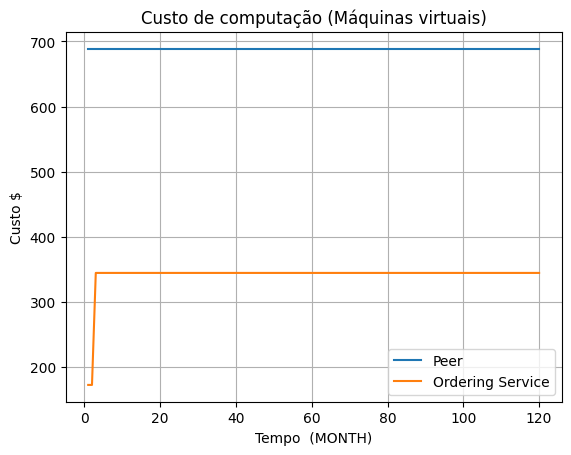

In [189]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, computer_cost_period_peer, label='Peer')
plt.plot(t, computer_cost_period_osn, label='Ordering Service')


ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo $')
plt.title('Custo de computação (Máquinas virtuais)')
plt.legend()
plt.show()

In [190]:
total_computer_cost_period = computer_cost_period_peer + computer_cost_period_osn

Custo total de computação somado: 

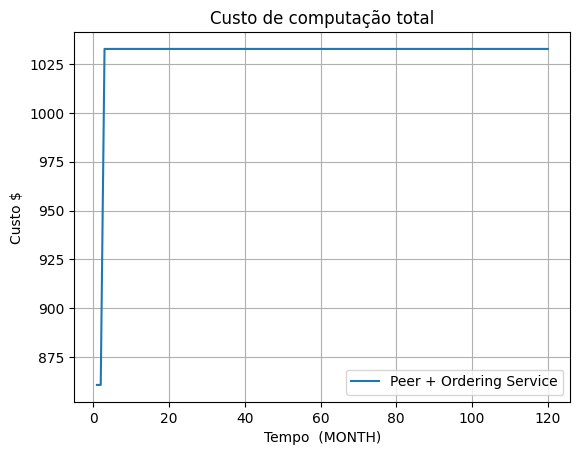

In [191]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, total_computer_cost_period, label='Peer + Ordering Service')



ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo $')
plt.title('Custo de computação total')
plt.legend()
plt.show()

# Network

Além dos recursos de computação e armazenamento, o tamanho das transações gerará custos tráfego de rede. O custo é por GB trafegado e por hora, desta forma, por exemplo, se 1 GB trafegar em um segundo, ou uma hora, esse 1 GB terá o mesmo custo, mais um o custo fixo de hora pré-fixado. 
<br>A comunicação interna, se ocorrer em recursos que utilizam a mesma sub-rede não é cobrada.

<p>

Normalmente, a exposição da da rede se dá através de um recurso *Endpoint* , que fornece uma conectividade privada através de uma interface virtual.
Em nosso modelo modelo, consideramos uma arquitetura com o cliente externo, com o Peer e Ordering Service (OS) na mesma sub-rede. Ou seja, o cliente para chegar no Peer e OS deve trafegar em entrada e saída.
Para o contexto do projeto, pacotes com pouca carga de dados, como *acknowledged* são desconsiderados.
</p>

<br><br>

<img src="./img/cliente_peer_osn.jpg" alt="Arquitetura fluxo Cliente Peer OSN " width="400"/>

<br><br>
Para o cálculo, consideramos a troca de mensagens 1, 2 e 3 no trafego cobrado e 4 (interna) 5 (linha pontilhada - confirmação) sem custo ou irrelevante.
O cliente pode ser 1 ou N clientes. A consistência se mantém na quantidade de mensagens de endosso (mostradas anteriormente conforme EndorsementPolicy escolhido) e todas as transações enviadas para o OrderingService.


In [192]:
transaction_size_gb                 = TRANSACTION_SIZE / BYTE_TO_GIGA
messages = 1 #Mensagens trocadas para deixar claro na multiplicação abaixo quantidade de troca de mensages

estimate_transaction_network_cost   = CLOUD_PRICING['NetworkThroughput']['PricingDataTransfer'] * transaction_size_gb

network_tput_cost_clients_to_endorsement_peer   =  endorsement_transactions     * (2*messages) * estimate_transaction_network_cost # step 1, 2
network_tput_cost_clients_to_ordering_server    =  total_transactions_by_period * (1*messages) *  estimate_transaction_network_cost #step 3

cost_endpoint =  CLOUD_PRICING['NetworkThroughput']['PricingDataTransfer'] * period_hours 
cost_endpoint_flat_rate = np.full(A, cost_endpoint)

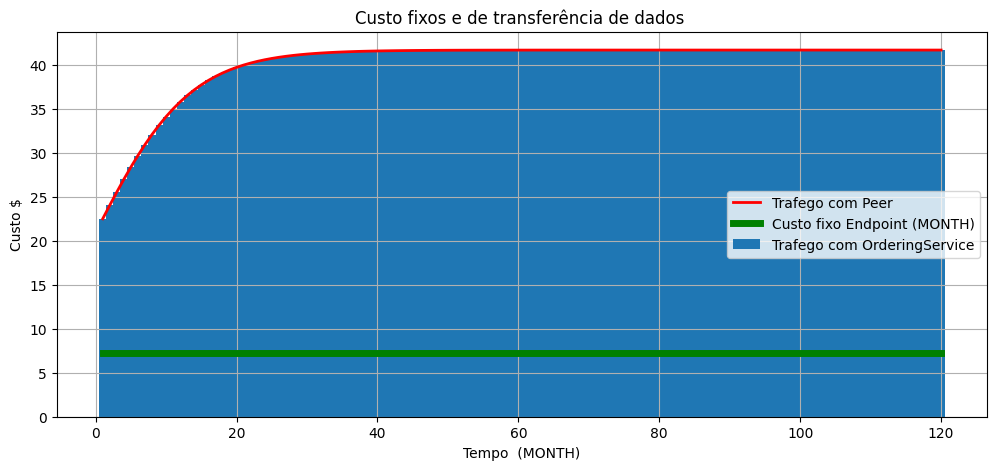

###  Tabela Custo fixos e de transferência de dados

Custo fixo Endpoint = 7.3

,Tempo(MONTH),Peer,OrderingService
10,11,$35.03,$35.03
20,21,$40.01,$40.01
30,31,$41.32,$41.32
40,41,$41.63,$41.63
50,51,$41.69,$41.69
60,61,$41.71,$41.71
70,71,$41.71,$41.71
80,81,$41.71,$41.71
90,91,$41.71,$41.71
100,101,$41.71,$41.71


In [193]:
# Gráfico de custos por destino e endpoint fixo

plt.figure(figsize=(12,5))
# Width of a bar 

plt.plot(t, network_tput_cost_clients_to_endorsement_peer, linewidth=2.0, label='Trafego com Peer', color='r') 
plt.plot(t, cost_endpoint_flat_rate, linewidth=5.0,label=f'Custo fixo Endpoint ({PREDICT_TYPE})', color='g') 
plt.bar(t, network_tput_cost_clients_to_ordering_server, 1.0  , label='Trafego com OrderingService')


plt.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo $')
plt.title('Custo fixos e de transferência de dados ')
plt.legend()
plt.show()


df = pd.DataFrame({f'Tempo({PREDICT_TYPE})': t, f'Peer': network_tput_cost_clients_to_endorsement_peer, f'OrderingService': network_tput_cost_clients_to_ordering_server })

df[f'Tempo({PREDICT_TYPE})']            = df[f'Tempo({PREDICT_TYPE})'].astype(int)
df['Peer']            = df['Peer'].apply(lambda x: f'${x:,.2f}')
df['OrderingService'] = df['OrderingService'].apply(lambda x: f'${x:,.2f}')


display(Markdown(f'###  Tabela Custo fixos e de transferência de dados'))
display(Markdown(f'Custo fixo Endpoint = {cost_endpoint}'))
df.iloc[int(A/(A/10)):A:int(A/(A/10))]

In [194]:
# Somatório dos custos
total_network_throughput_cost = network_tput_cost_clients_to_ordering_server + network_tput_cost_clients_to_endorsement_peer + cost_endpoint_flat_rate

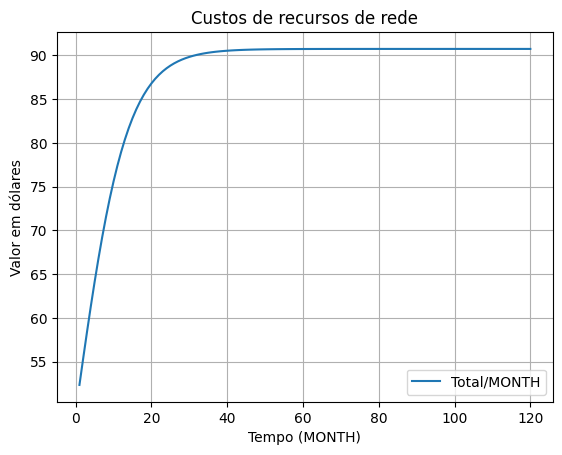

,Tempo (MONTH),Total/MONTH
10,11.00,77.35
20,21.00,87.32
30,31.00,89.94
40,41.00,90.55
50,51.00,90.69
60,61.00,90.72
70,71.00,90.73
80,81.00,90.73
90,91.00,90.73
100,101.00,90.73


In [195]:
# Custo total de recursos de rede
fig, ax, df = simple_plot(x= t, y= total_network_throughput_cost, line_label=f'Total/{PREDICT_TYPE}', ylabel='Valor em dólares', title= f'Custos de recursos de rede', tlabel_style='plain', create_df=False)

plt.show()
df.iloc[int(A/(A/10)):A:int(A/(A/10))]


# CUSTOS TOTAL

Com base nas análises acima, os principais resultados de custos são demonstrados abaixo.


### Custos por recurso:

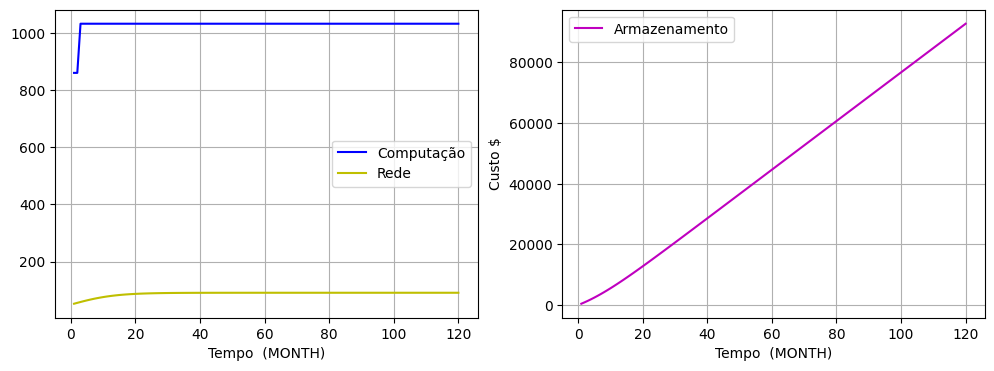

###  Tabela demonstrativo de custo de cada recurso para o período selecionado:

,Tempo(MONTH),Computação,Rede,Armazenamento
10,11,"$1,032.80",$77.35,"$6,185.41"
20,21,"$1,032.80",$87.32,"$13,538.44"
30,31,"$1,032.80",$89.94,"$21,401.48"
40,41,"$1,032.80",$90.55,"$29,389.95"
50,51,"$1,032.80",$90.69,"$37,407.06"
60,61,"$1,032.80",$90.72,"$45,430.59"
70,71,"$1,032.80",$90.73,"$53,455.56"
80,81,"$1,032.80",$90.73,"$61,480.84"
90,91,"$1,032.80",$90.73,"$69,506.20"
100,101,"$1,032.80",$90.73,"$77,531.57"


In [196]:
# Custo de cada recurso total por período 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(t, total_computer_cost_period, label='Computação', color='b')
ax1.plot(t, total_network_throughput_cost, label='Rede', color='y')

ax1.set_xlabel(f'Tempo  ({PREDICT_TYPE})')
ax1.legend()
ax1.grid(True)

ax2.plot(t, total_storage_cost, label='Armazenamento', color='m')


plt.grid(True)

plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo $')
plt.title('')
plt.legend()
plt.show()

df = pd.DataFrame({f'Tempo({PREDICT_TYPE})': t, f'Computação': total_computer_cost_period, f'Rede': total_network_throughput_cost,  f'Armazenamento': total_storage_cost })

df[f'Tempo({PREDICT_TYPE})']            = df[f'Tempo({PREDICT_TYPE})'].astype(int)
df['Computação']            = df['Computação'].apply(lambda x: f'${x:,.2f}')
df['Rede'] = df['Rede'].apply(lambda x: f'${x:,.2f}')
df['Armazenamento'] = df['Armazenamento'].apply(lambda x: f'${x:,.2f}')

display(Markdown(f'###  Tabela demonstrativo de custo de cada recurso para o período selecionado:'))
df.iloc[int(A/(A/10)):A:int(A/(A/10))]

## Somatório do custo de todos os recursos:

In [197]:
# Somatório de todos os recursos
total_cost = total_computer_cost_period + total_network_throughput_cost + total_storage_cost

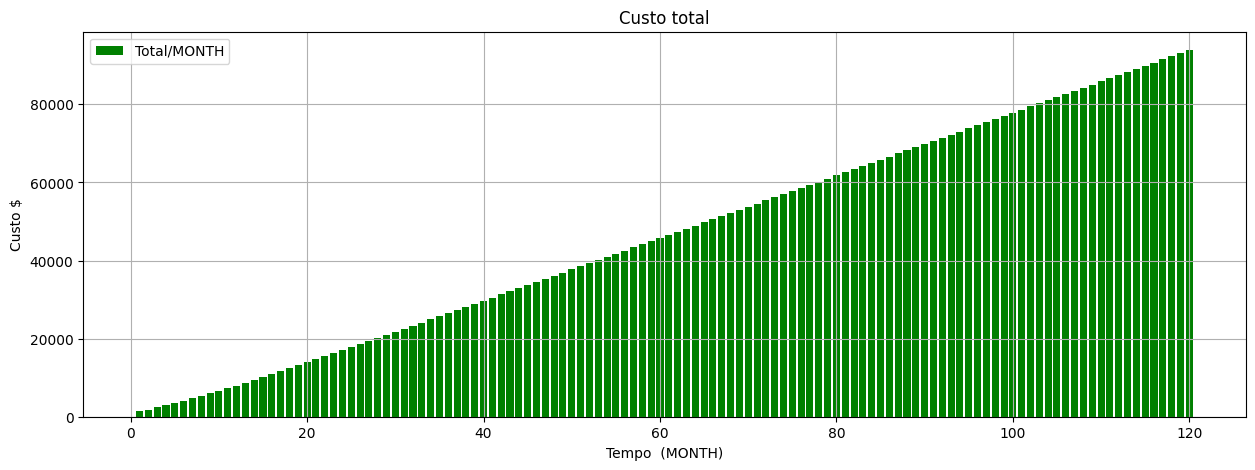

In [198]:
fig, ax = plt.subplots(1, figsize=(15, 5))
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.bar(t, total_cost, label=f'Total/{PREDICT_TYPE}', color='g')
ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo $')
plt.title('Custo total')
plt.legend()
plt.show()

df = pd.DataFrame({f'Tempo({PREDICT_TYPE})': t, f'Custo total': total_cost})

df[f'Tempo({PREDICT_TYPE})']            = df[f'Tempo({PREDICT_TYPE})'].astype(int)
df['Custo total'] = df['Custo total'].apply(lambda x: f'${x:,.2f}')

In [199]:
display(Markdown(f'###  Tabela demonstrativo de custo de todos os recursos'))
df.iloc[int(A/(A/10)):A:int(A/(A/10))]

###  Tabela demonstrativo de custo de todos os recursos

,Tempo(MONTH),Custo total
10,11,"$7,295.57"
20,21,"$14,658.56"
30,31,"$22,524.23"
40,41,"$30,513.31"
50,51,"$38,530.55"
60,61,"$46,554.11"
70,71,"$54,579.08"
80,81,"$62,604.37"
90,91,"$70,629.73"
100,101,"$78,655.10"


In [200]:
df

,Tempo(MONTH),Custo total
0,1,"$1,343.68"
1,2,"$1,807.04"
2,3,"$2,471.44"
3,4,"$2,991.65"
4,5,"$3,538.62"
...,...,...
115,116,"$90,693.17"
116,117,"$91,495.70"
117,118,"$92,298.24"
118,119,"$93,100.78"


# Conclusão

Analisando os cenários com valores nominais, percebe-se um crescimento disparado de armazenamento sobre os outros recursos de computação e rede. 
<br>
O custo de computação e rede está diretamente ligado ao tempo de execução, isto é, é proporcional a computação utilizada, logo, se o uso da blockchain for descontinuado, este custo não existirá. 

</p>
Por outro lado, o custo armazenamento é crescente e cumulativo. Isso pode ser decisivo nas tomadas de decisões a longo prazo. 
<br>
O principal aspecto é que mesmo que uma organização deixe de utilizar a blockchain, a depender da legislação aplicada, deverá manter estes dados por período determinado, mantendo o custo de armazenamento.

Dito isso, as organizações devem buscar a eficiência da rede blockchain, utilizando os *smartcontracts* de maneira assertiva, evitando, por exemplo, transações inválidas que também são gravadas no Ledger.

<p>
Neste sentido, este projeto contribui para que organizações e interessados tenham previsibilidade do custo de nuvem se essa for utilizada, mas também dos recursos necessário, como armazenamento necessário, independente do ambiente a ser executado.